# Wstęp

Do tej pory próbowaliśmy podzielić na grupy przedmioty według podobieństwa ich nazw. W tym notebooku sprawdzam inne podejście - dzielę sprzedaż danego produktu na okresy, np. kwartały i grupuję produkty, których wzorzec sprzedaży jest podobny.

Dla przykładu - *Biała osłona na kaloryfer 112 cm* oraz *Siatka ogrodzeniowa Metal + PCV, rolka 1m x 25m.* wydają się mieć podobną sprzedaż kwartalną i mogłoby trafić do tej samej grupy, zaś *Duży stół jadalnia salon 160x80x75 * BIAŁY* czy *Wisząca lampa sufitowa z kryształkami, chromowa* mają zupełnie inny wzorzec sprzedaży, co można zauważyć na poniższych wykresach:

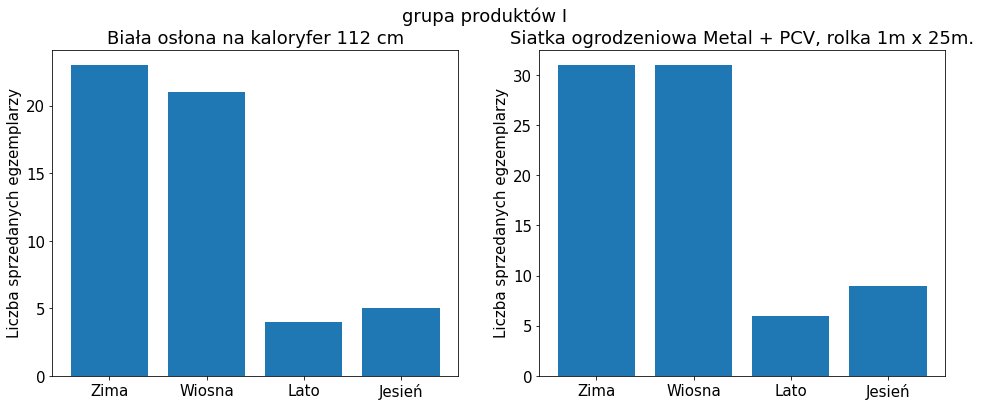

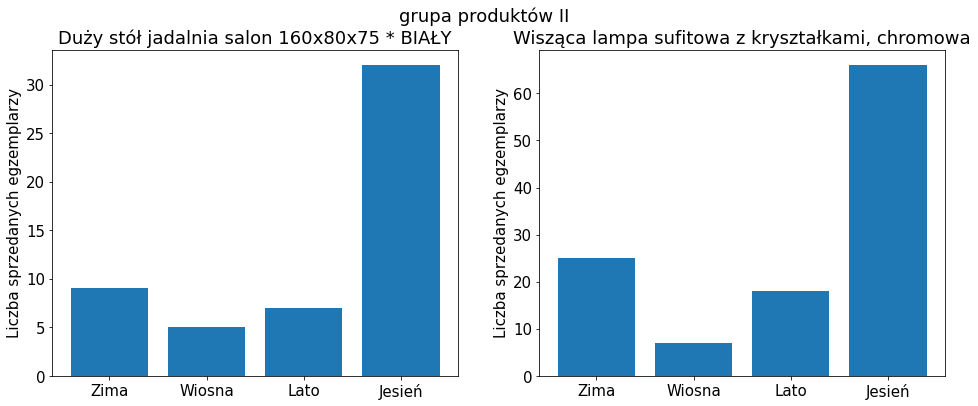

In [264]:
names = ["Biała osłona na kaloryfer 112 cm", "Siatka ogrodzeniowa Metal + PCV, rolka 1m x 25m.", "Duży stół jadalnia salon 160x80x75 * BIAŁY", "Wisząca lampa sufitowa z kryształkami, chromowa"]

fig, axes = plt.subplots(1,2, figsize = (16,6))
for i, ax in enumerate(axes.flatten()):
    plot_seasonality(df, names[i], "quarter", ax)
fig.suptitle("grupa produktów I")
plt.show()

fig, axes = plt.subplots(1,2, figsize = (16,6))
for i, ax in enumerate(axes.flatten()):
    plot_seasonality(df, names[i+2], "quarter", ax)
fig.suptitle("grupa produktów II")
plt.show()

# Obliczenia

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date, timedelta
import numpy as np

%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 8]
plt.rcParams.update({'font.size': 15})

## Czyszczenie danych

In [4]:
def finder(phrase):
    return lambda product_name: str(product_name).find(phrase)

DATA_FILE = 'shumee_mckinsey -Aktualizacja 01.03.xlsx'

df_org = pd.read_excel(DATA_FILE, engine='openpyxl')
df = df_org[df_org['ID zamówienia'].notna()]  # usunięcie wpisów gdzie ID zamówienia == NaN
df = df[df['Nazwa produktu'] != 'Przesyłka pobraniowa']
df = df[df['Nazwa produktu'].map(finder("Kod rabatowy")) == -1]  # usuniecie kodow rabatowych
df = df[df['Miasto'] != 'test']
df = df[df['Miasto'] != 'Test']
df = df[df['Miasto'] != 'TEST']
df = df[df['Miasto'] != 'ssss']
df = df[df['Miasto'] != 'asd']
df = df[df['Miasto'] != 'asdasd']
df = df[df['Miasto'] != 'dsss']
df = df[df['Nazwa produktu'].map(finder("TESTOWY PRODUKT")) == -1]
df = df[df['Nazwa produktu'].map(finder("PRODUKT TESTOWY")) == -1]
df = df[df['Cena'] >= 0]  # usuniecie kodow rabatowych
# akceptuję produkty z ceną 0 zł, ponieważ są to produkty zamówione osobiście lub też telefonicznie

In [7]:
# df.to_csv("shumee_data", index=False)

df = pd.read_csv("shumee_data")
df["Data"] = pd.to_datetime(df["Data"])

## Definiuję użyteczne funkcje

In [107]:
def seasonal_sells(df, name, season):
    """Returns pd.Series with sells of a product of the given name. The sells are partitioned with respect to the season.
    :param df: pd.DataFrame with the Shumee data
    :param name: the name of the product considered
    :param season: possible seasons are ["quarter", "month", "weekday", "hour", "total"]. "Total" means returning the sells from the first day up to the last day, day by day.
    :return: pandas.Series
    """
    
    if season == "quarter":
        sells = df[df["Nazwa produktu"]==name].groupby(df["Data"].dt.quarter)
#         sells = sells["Ilość"].sum()
        sells = sells["ID zamówienia"].nunique()
        sells = sells.reindex(range(1,5), fill_value = 0)
        
    elif season == "month":
        sells = df[df["Nazwa produktu"]==name].groupby(df["Data"].dt.month)
        # sells = sells["Ilość"].sum()
        sells = sells["ID zamówienia"].nunique()
        sells = sells.reindex(range(1,13), fill_value = 0)
        
    elif season == "weekday":
        sells = df[df["Nazwa produktu"]==name].groupby(df["Data"].dt.weekday)
#         sells = sells["Ilość"].sum()
        sells = sells["ID zamówienia"].nunique()
        sells = sells.reindex(range(0,7), fill_value = 0)
        
    elif season =="hour":
        sells = df[df["Nazwa produktu"]==name].groupby(df["Data"].dt.hour)
#         sells = sells["Ilość"].sum()
        sells = sells["ID zamówienia"].nunique()
        sells = sells.reindex(range(0,7), fill_value = 0)
        
    elif "total":
        # The first day Shumee started gathering the data
        first_day = df["Data"].dt.date.min()
        # The last day
        last_day = df["Data"].dt.date.max()
        dti_days = pd.date_range(start=first_day, end=last_day, freq="D")
        
        sells = df[df["Nazwa produktu"]==name].groupby(df["Data"].dt.date)
#         sells = sells["Ilość"].sum()
        sells = sells["ID zamówienia"].nunique()
        sells = sells.reindex(dti_days, fill_value = 0)
        
    return sells

def plot_seasonality(df, name, season, ax=None):
    """Plot the seasonal sells returned by seasonal_sells().
    
    :param df: pd.DataFrame with the Shumee data
    :param name: the name of the product considered
    :param season: possible seasons are ["quarter", "month", "weekday", "hour", "total"]. "Total" means returning the sells from the first day up to the last day, day by day.
    :return: None
    """
    sells = seasonal_sells(df, name, season)
    
    if ax is None:
        fig, ax = plt.subplots(1,1)
    
    if season == "quarter":
        ax.bar(range(4), sells, tick_label = ["Zima", "Wiosna", "Lato", "Jesień"])
        ax.set_ylabel("Liczba sprzedanych egzemplarzy")
        ax.set_title(f"{name}")

    elif season == "month":
        ax.bar(range(12), sells, tick_label = "Sty Lut Mar Kwi Maj Cze Lip Sie Wrz Paz Lis Gru".split(" "))
        ax.set_ylabel("Liczba sprzedanych egzemplarzy")
        ax.set_title(f"{name}")
        
    elif season == "week":
        ax.bar(range(7), sells, tick_label = "Pon Wt Śr Czw Pt Sob Nd".split(" "))
        ax.set_ylabel("Liczba sprzedanych egzemplarzy")
        ax.set_title(f"{name}")
        
    elif season =="hour":
        sells.plot(marker="o")
        ax.set_ylabel("Liczba sprzedanych egzemplarzy")
        ax.set_xlabel("Godzina")
        ax.set_title(f"{name}")
        
    elif "total":
        sells.plot()
        ax.set_ylabel("Liczba sprzedanych egzemplarzy")
        ax.set_title(f"Sprzedaż {name}")

## Usunięcie produktów sprzedawanych mniej niż rok

In [53]:
sells_duration = df["Data"].groupby(df["Nazwa produktu"]).max() - df["Data"].groupby(df["Nazwa produktu"]).min()

In [60]:
# Lista nazw produktów sprzedawanych co najmniej rok:
longer_than_year = sells_duration[sells_duration > timedelta(days=365)].index

In [63]:
df = df[df['Nazwa produktu'].map(lambda name: True if name in longer_than_year else False)]

## Tworzę DataFrame, w którym trzymam sezonowość różnych produktów

In [76]:
# product_names = df["Nazwa produktu"].unique()
sells_threshold = 50
product_names = df.groupby("Nazwa produktu")["ID zamówienia"].nunique()
# product_names = df.groupby("Nazwa produktu")["Ilość"].sum()
product_names = product_names[product_names > sells_threshold].index

# seasonal_variances = {'quarter' : [],
#                       'month' : [],
#                       'weekday' : [],                
#                       'hour' : []
#                      }
# total_sells = []

seasonal_variances = {'quarter' : [],
                      'month' : []
                     }

for i, name in enumerate(product_names):
        
    # total_sells.append(df[df["Nazwa produktu"]==name]["Ilość"].sum())
    
    for season, var in seasonal_variances.items():
        var.append(seasonal_sells(df, name, season).var())

In [77]:
seasonality = pd.DataFrame(data = seasonal_variances,
                           index = product_names)
                            
seasonality.head()

,quarter,month
Nazwa produktu,,
2-częściowy garnitur biznesowy męski czarny rozmia,11.000000,4.151515
2-częściowy garnitur męski z krawatem biały rozmia,18.000000,4.242424
6 Bambusowych brązowych podkładek pod talerze 30 x,150.666667,28.787879
Aluminiowe koło podporowe/manewrowe do przyczepy 1,148.666667,24.909091
Automatyczny system nawadniania ze zraszaczem i wł,2458.916667,327.719697


## Największa sezonowość kwartalna

In [79]:
print("Największa sezonowość kwartalna:")
seasonality["quarter"].sort_values(ascending=False)[:10]

Największa sezonowość kwartalna:


Nazwa produktu
Zaczepy do przyczepki rowerowej, 2 szt., żelazne      3652.000000
Daszek do automatycznej kosiarki 77x103x46 cm         3362.000000
Zaczep do przyczepki rowerowej żelazny                3170.916667
Automatyczny system nawadniania ze zraszaczem i wł    2458.916667
Wypukłe lustro drogowe, 30 cm, czarne                 1444.250000
Lampa sufitowa, plafon, białe i bezbarwne listki 3    1350.916667
Stolik barowy z półkami, biały, 110 x 50 x 103 cm     1208.666667
Fontanna pokojowa ze światłem LED, żywica syntetyc    1054.250000
Zestaw zawieszenia tła 300 cm szeroki bez płótna       977.583333
Zadaszenie altany, 2-poziomowe, 310 g/m, 3 x 3 m,      958.916667
Name: quarter, dtype: float64

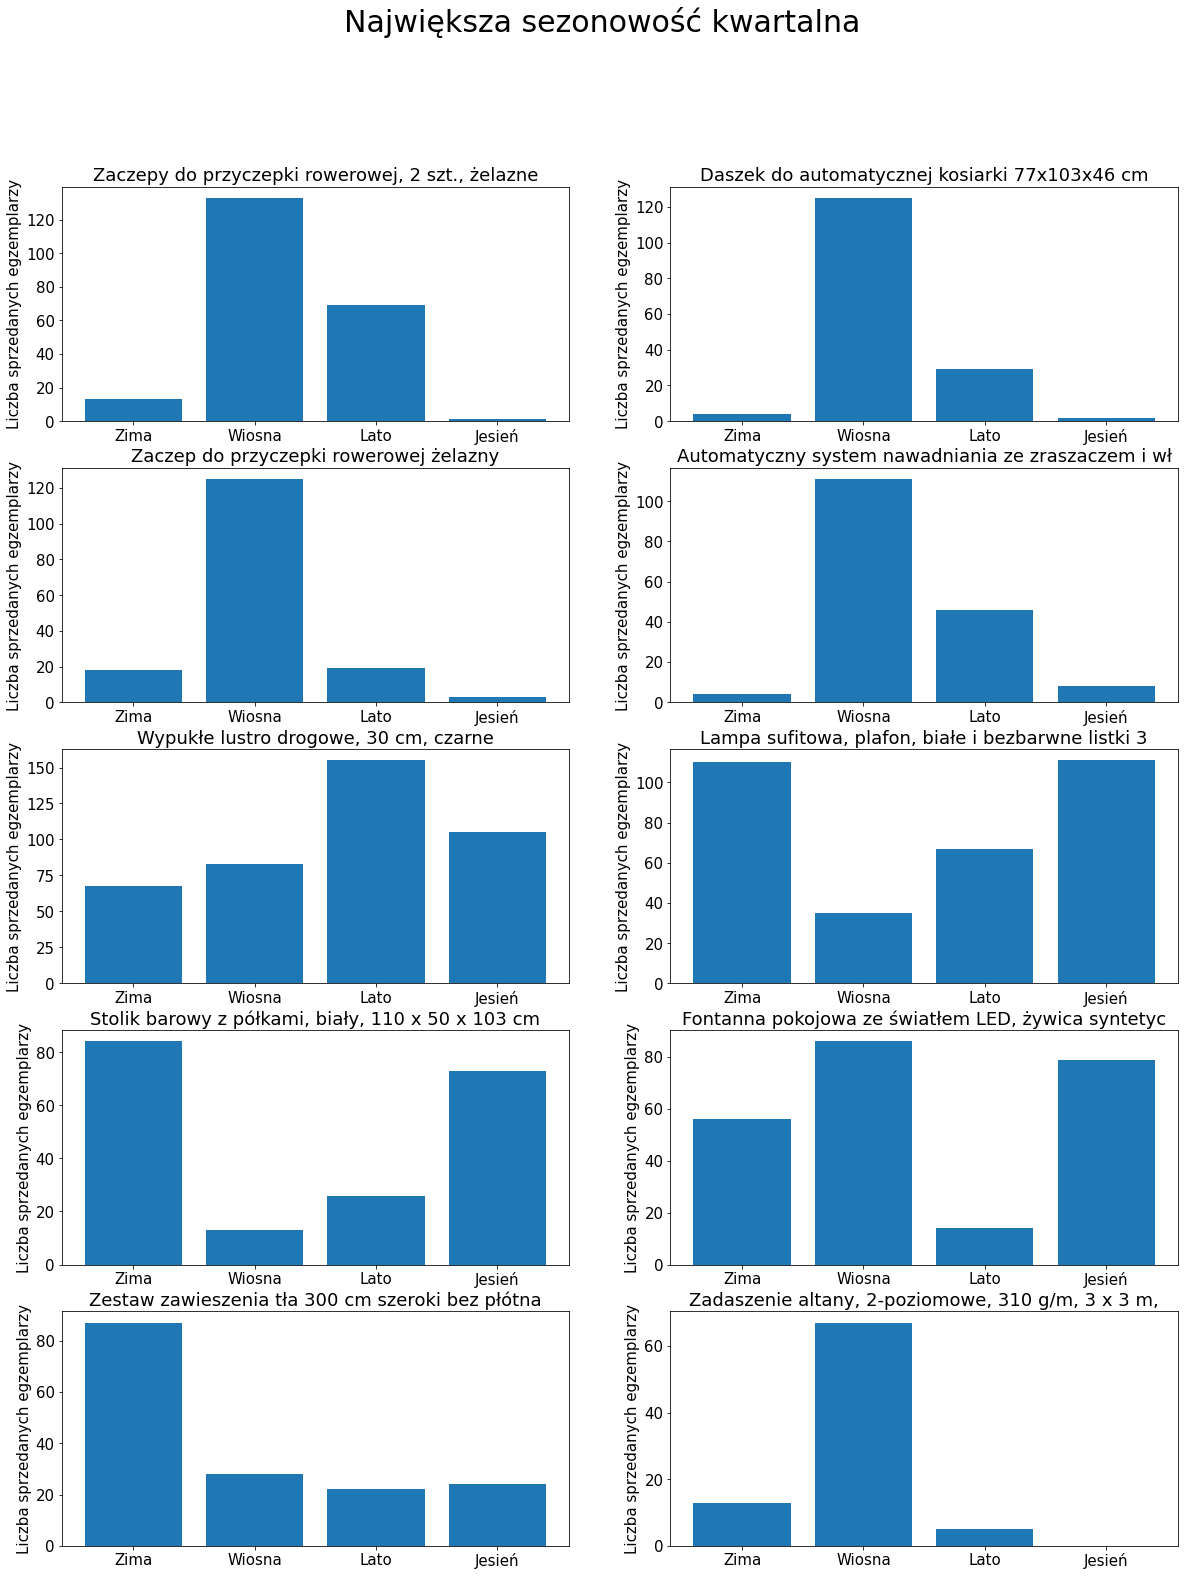

In [113]:
fig, axes = plt.subplots(5, 2, figsize = (20, 25))
names_of_most_seasonal = seasonality["quarter"].sort_values(ascending=False).index
for i, ax in enumerate(axes.flatten()):
    plot_seasonality(df, names_of_most_seasonal[i], "quarter", ax)
    
fig.suptitle("Największa sezonowość kwartalna", fontsize=30)
plt.show()

Dla porównania, możemy też obejrzeć przedmioty o najmniejszej sezonowości kwartalnej.

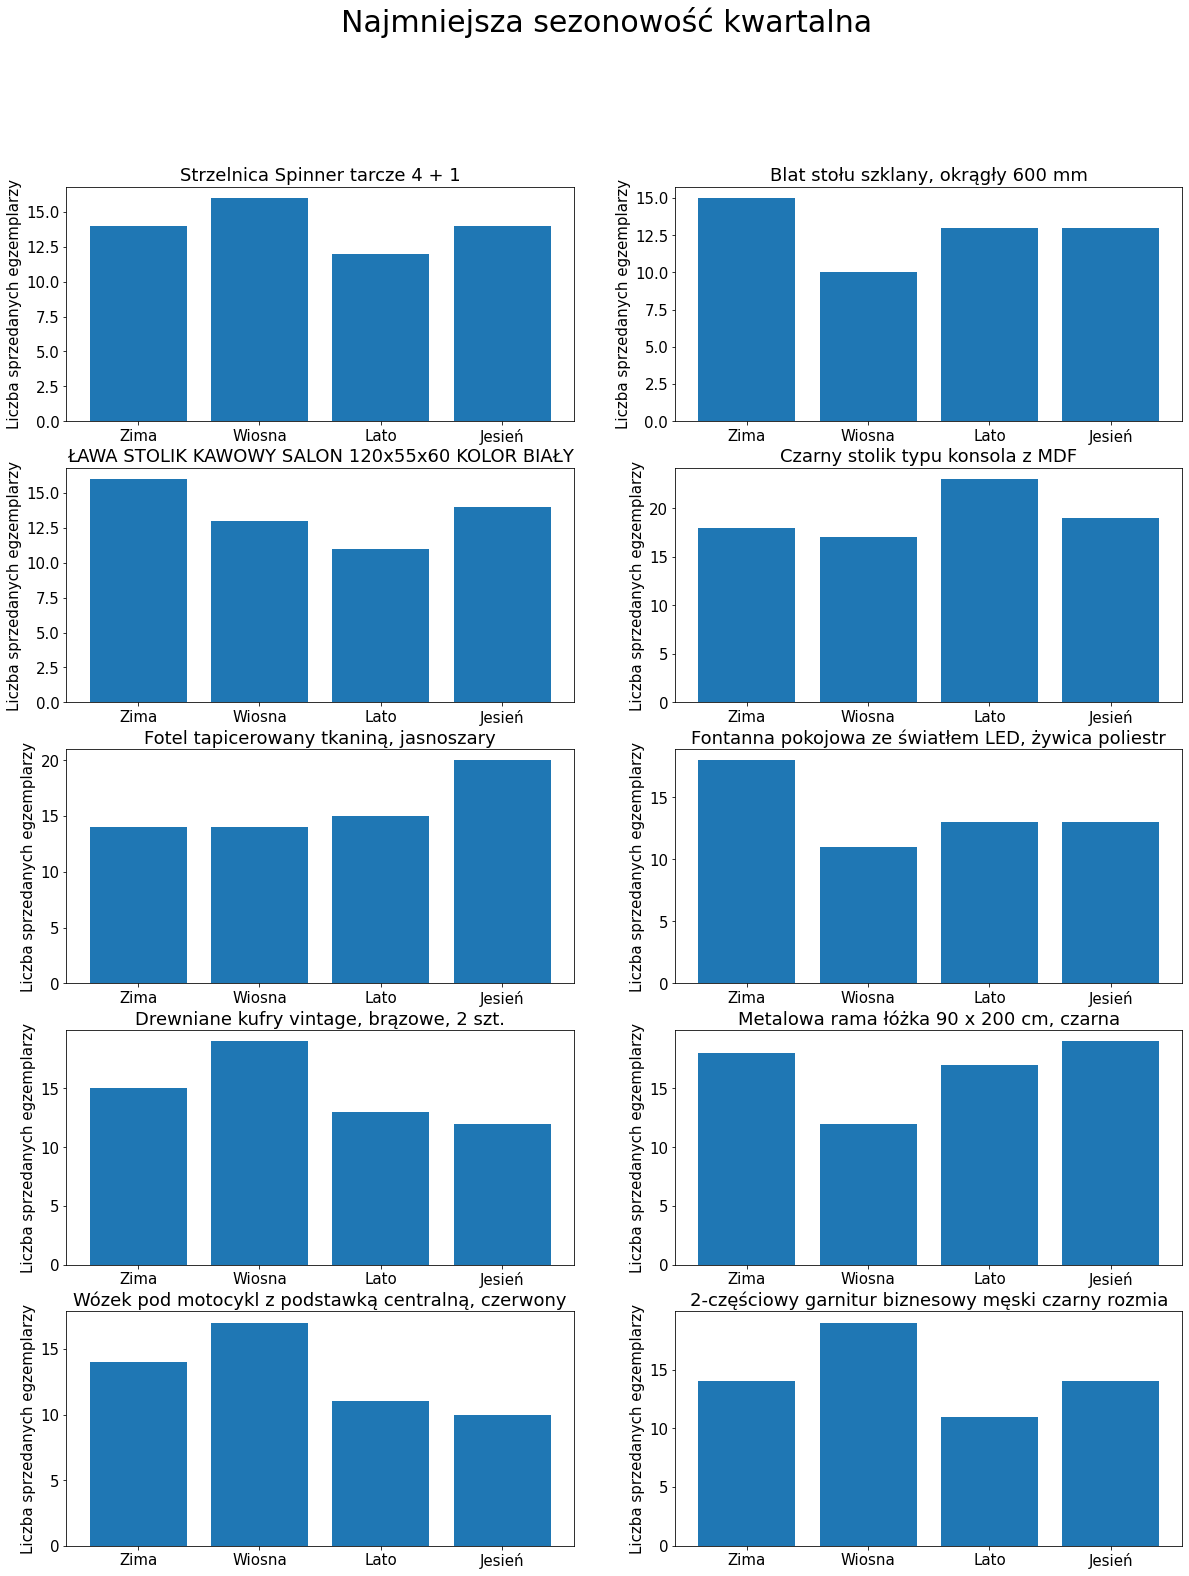

In [115]:
fig, axes = plt.subplots(5, 2, figsize = (20, 25))
names_of_most_seasonal = seasonality["quarter"].sort_values(ascending=True).index
for i, ax in enumerate(axes.flatten()):
    plot_seasonality(df, names_of_most_seasonal[i], "quarter", ax)
    
fig.suptitle("Najmniejsza sezonowość kwartalna", fontsize=30)
plt.show()

## Największa sezonowość miesięczna

In [110]:
print("Największa sezonowość miesięczna:")
seasonality["month"].sort_values(ascending=False)[:10]

Największa sezonowość miesięczna:


Nazwa produktu
Zaczepy do przyczepki rowerowej, 2 szt., żelazne      558.909091
Zaczep do przyczepki rowerowej żelazny                453.840909
Daszek do automatycznej kosiarki 77x103x46 cm         398.606061
Automatyczny system nawadniania ze zraszaczem i wł    327.719697
Kosz do segregacji śmieci z pedałami, stal nierdze    218.992424
Wypukłe lustro drogowe, 30 cm, czarne                 214.568182
Lampa sufitowa, plafon, białe i bezbarwne listki 3    194.265152
Półki ścienne, 3 szt., białe, płyta wiórowa           163.878788
Zestaw zawieszenia tła 300 cm szeroki bez płótna      158.810606
Fontanna pokojowa ze światłem LED, żywica syntetyc    148.992424
Name: month, dtype: float64

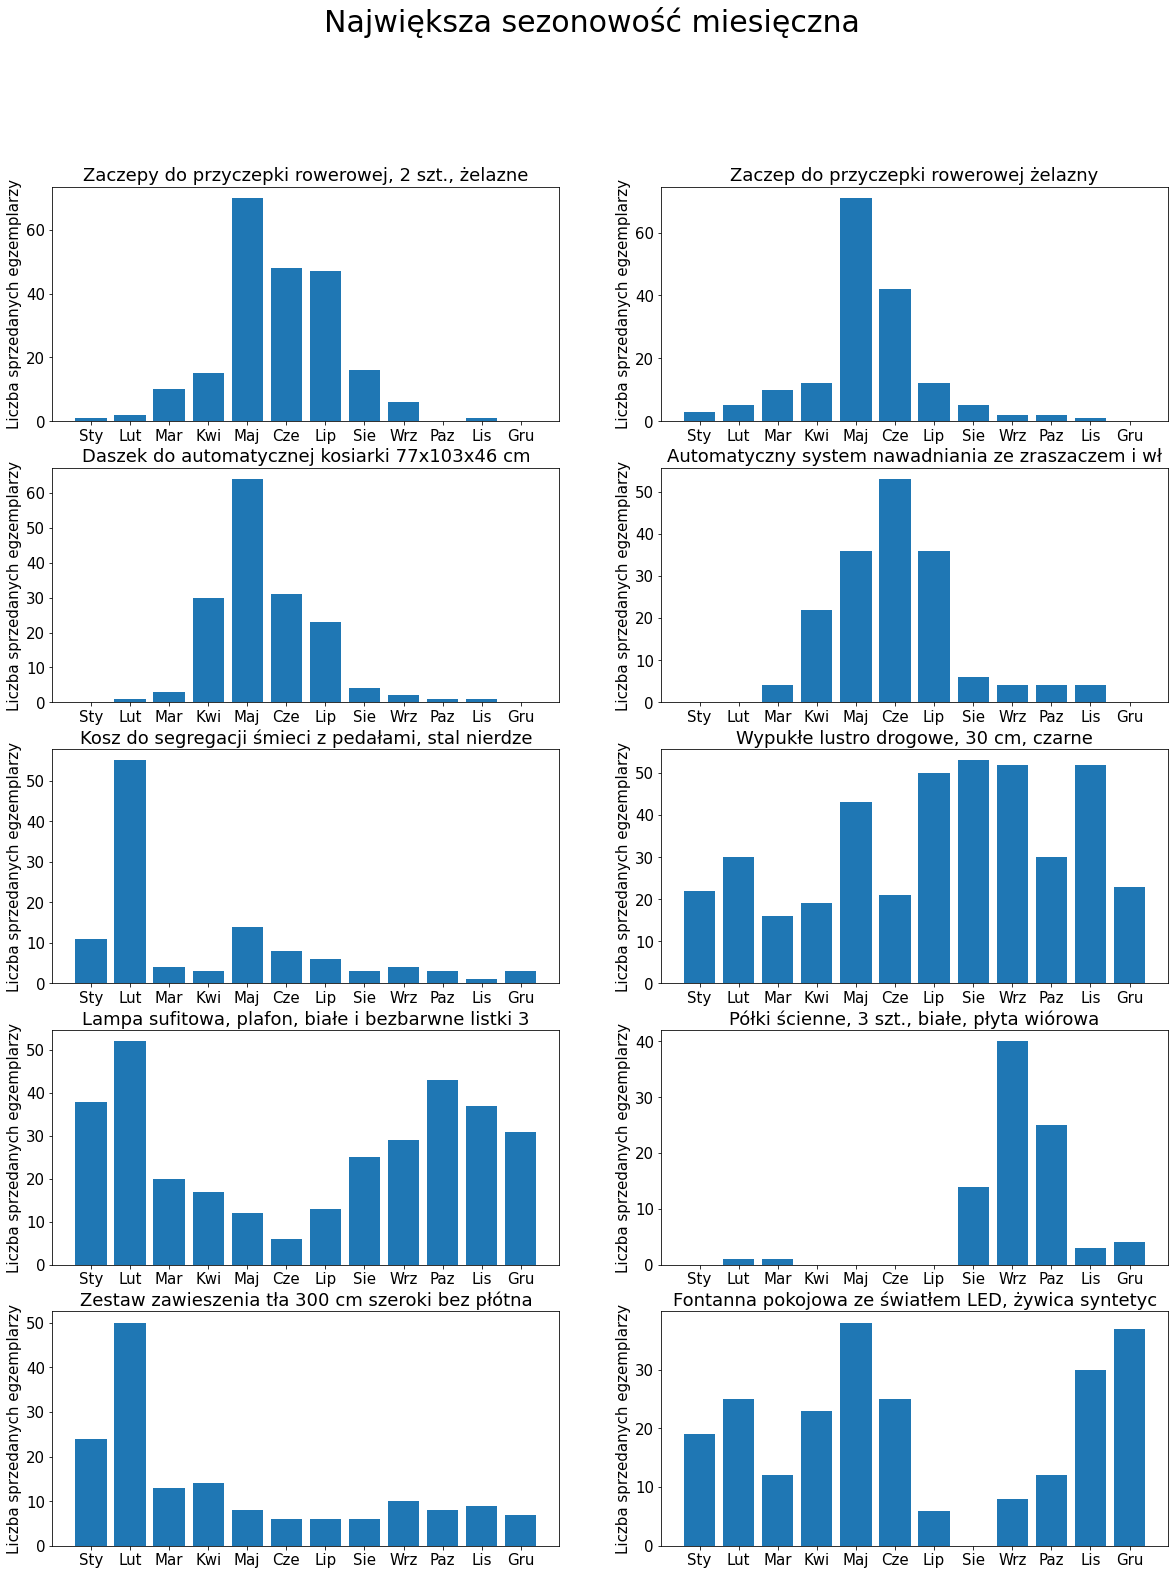

In [114]:
fig, axes = plt.subplots(5, 2, figsize = (20, 25))
names_of_most_seasonal = seasonality["month"].sort_values(ascending=False).index
for i, ax in enumerate(axes.flatten()):
    plot_seasonality(df, names_of_most_seasonal[i], "month", ax)
    
fig.suptitle("Największa sezonowość miesięczna", fontsize=30)
plt.show()

Oraz dla porównania najmniejsza sezonowość miesięczna.

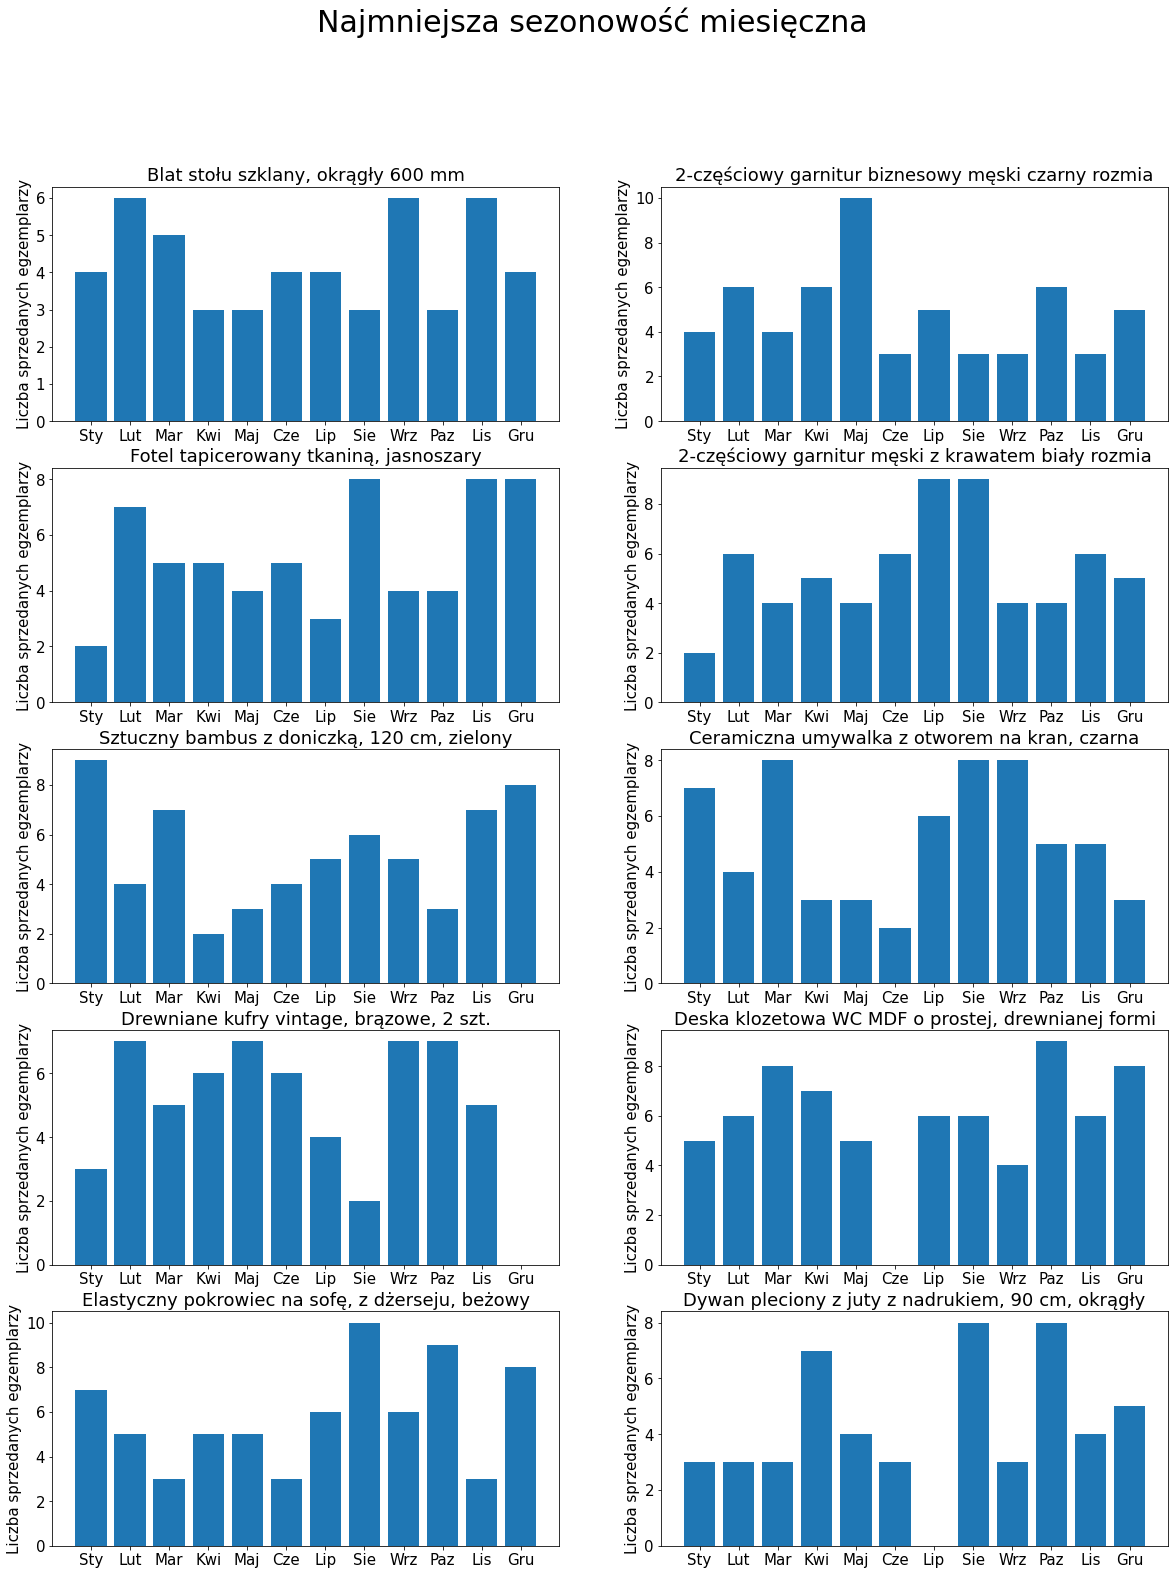

In [118]:
fig, axes = plt.subplots(5, 2, figsize = (20, 25))
names_of_least_seasonal = seasonality["month"].sort_values(ascending=True).index
for i, ax in enumerate(axes.flatten()):
    plot_seasonality(df, names_of_least_seasonal[i], "month", ax)
    
fig.suptitle("Najmniejsza sezonowość miesięczna", fontsize=30)
plt.show()

## Zgrupowanie przedmiotów o podobnej sezonowości kwartalnej

Sezonowość kwartalną każdego produktu potraktuję jako wektor wymiaru 4. Np. *Zaczepy do przyczepki rowerowej, 2 szt., żelazne* miały sprzedaż 13 na zimę, 133 na wiosnę, 69 na lato i 1 na jesień, dlatego odpowiada im wektor $(13, 133, 69, 1)$.

Ponieważ różne produkty były sprzedawane w różnej ilości, to każdy taki wektor normalizuje, dzieląc go przez jego długość. W przypadku Zaczep do przyczepki rowerowej efektem będzie wektor $(0.08643648, 0.88431164, 0.45877822, 0.00664896)$. Dzięki temu wszystkie wektory są tej samej długości i wskazują pewien kierunek, np "wiosna".

In [143]:
sells_threshold = 50
product_names = df.groupby("Nazwa produktu")["ID zamówienia"].nunique()
product_names = product_names[product_names > sells_threshold].index

seasonal_variances = {'quarter' : [],
                      'month' : []
                     }

sells_quaterly = {}

for i, name in enumerate(product_names):
    sells_quaterly[name] = seasonal_sells(df, name, "quarter")
    
sells_quaterly = pd.DataFrame(sells_quaterly).transpose()

# Normalizacja
sells_quaterly = sells_quaterly.apply(func = lambda row: row/np.linalg.norm(row), axis = 1)

In [145]:
sells_quaterly.head()

Data,1,2,3,4
2-częściowy garnitur biznesowy męski czarny rozmia,0.473557,0.642685,0.372081,0.473557
2-częściowy garnitur męski z krawatem biały rozmia,0.365487,0.456859,0.670059,0.456859
6 Bambusowych brązowych podkładek pod talerze 30 x,0.321521,0.091863,0.688973,0.643041
Aluminiowe koło podporowe/manewrowe do przyczepy 1,0.136285,0.654167,0.735938,0.109028
Automatyczny system nawadniania ze zraszaczem i wł,0.033199,0.921265,0.381785,0.066397


### DBSCAN na sezonowości kwartalnej

In [208]:
from sklearn.cluster import DBSCAN
from collections import defaultdict

In [158]:
X = sells_quaterly.to_numpy()

In [233]:
clustering = DBSCAN(eps=0.01, metric = 'cosine', min_samples=2).fit(sells_quaterly)

n_clusters = len(set(clustering.labels_))
print(f"Znaleziono {n_clusters} klastrów. {sum(clustering.labels_==-1)} produktów to outliery.")

Znaleziono 25 klastrów. 30 produktów to outliery.


In [ ]:
names_clustered = defaultdict(list)

for idx, name in enumerate(sells_quaterly.index):
    names_clustered[clustering.labels_[idx]].append(name)

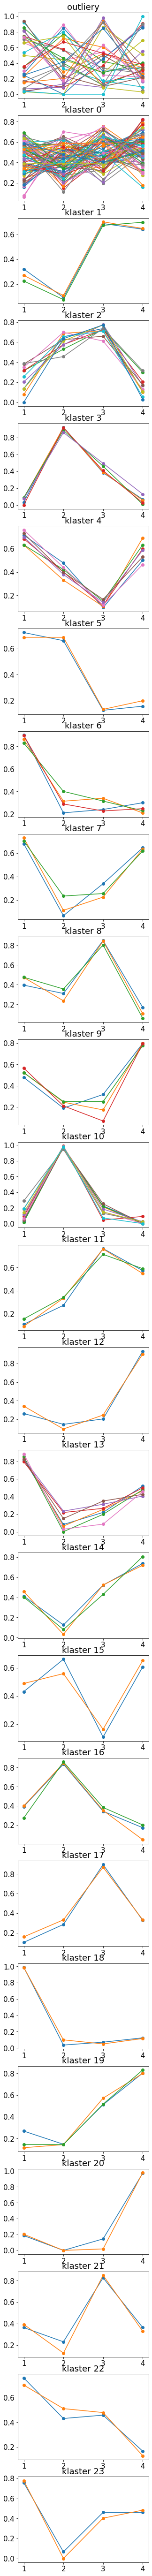

In [246]:
fig, axes = plt.subplots(n_clusters, 1, figsize = (5,4*n_clusters))

for i in range(-1, n_clusters-1):
    if i == -1:
        axes[i+1].set_title("outliery")
    else:
        axes[i+1].set_title(f"klaster {i}")
    for name in names_clustered[i]:
        axes[i+1].plot(sells_quaterly.loc[name], marker="o")

In [242]:
for i in range(n_clusters - 1):
    print(f"Cluster {i}:")
    print(sells_quaterly[clustering.labels_ == i].index.to_list())
    print("\n")

Cluster 0:
['2-częściowy garnitur biznesowy męski czarny rozmia', '2-częściowy garnitur męski z krawatem biały rozmia', 'Bawełniana narzuta w jodełkę, 160 x 210 cm, szara', 'Bawełniana narzuta w jodełkę, 220 x 250 cm, szara', 'Blat stołu szklany, okrągły 600 mm', 'Brodzik prysznicowy prostokątny ABS biały 70 x 120', 'Brodzik prysznicowy, SMC, czarny, 100 x 80 cm', 'CZYSTA KABINA PRYSZNICOWA 500 ml Sann Profi', 'Ceramiczna umywalka Czarna okrągła', 'Ceramiczna umywalka narożna z otworem przelewowym', 'Ceramiczna umywalka z otworem na kran, czarna', 'Czarny stolik typu konsola z MDF', 'Deska klozetowa WC MDF o prostej, drewnianej formi', 'Deska sedesowa, wolnoopadająca, z szybkozłączem, c', 'Drewniane kufry vintage, brązowe, 2 szt.', 'Dywan pleciony z juty z nadrukiem, 90 cm, okrągły', 'Dywan pleciony z juty, 90 cm, okrągły', 'Elastyczne pokrowce na krzesła w prostym stylu brą', 'Elastyczny pokrowiec na fotel, z dżerseju, antracy', 'Elastyczny pokrowiec na fotel, z dżerseju, beżowy', 'El

Wygląda na to, że to klastra 0 trafiły produkty, której nie dało się przyporządkować nigdzie indziej i cechują się one słabą sezonowością. Przedmioty, których sprzedaż jest wyraźnie sezonowa "ładnie" podzieliły się na grupy.